In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# More ideas to explore

+ Potentially add a simple routing model
+ Nicer clustering than kmeans (DBSCAN used too much RAM)


# References


1.   Visualization: [the Kaggle competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) on  New York City Taxi Fare Prediction
2.   AB testing: [Uber Engineering](https://eng.uber.com/xp/)




# Setup

In [ ]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN 

from xgboost import XGBRegressor

# Data processing and a first look at the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 df = pd.read_csv('/content/drive/My Drive/Bolt/robotex5.csv', sep=',', parse_dates=['start_time'])

In [ ]:
df.head()

start_time  start_lat  start_lng    end_lat    end_lng  \
0  2022-03-06 15:02:39.329452000  59.407910  24.689836  59.513027  24.831630   
1  2022-03-10 11:15:55.177526000  59.441650  24.762712  59.426450  24.783076   
2  2022-03-06 14:23:33.893257000  59.435404  24.749795  59.431901  24.761588   
3  2022-03-03 09:11:59.104192000  59.406920  24.659006  59.381093  24.641652   
4  2022-03-06 00:13:01.290346000  59.434940  24.753641  59.489203  24.876170   

   ride_value  
0     3.51825  
1     0.50750  
2     0.19025  
3     0.75600  
4     2.27100

In [ ]:
df.info()

In [ ]:
df.describe()

start_lat      start_lng        end_lat        end_lng  \
count  627210.000000  627210.000000  627210.000000  627210.000000   
mean       59.428682      24.743468      59.397797      24.724847   
std         0.021764       0.056872       1.392755       1.650709   
min        59.321557      24.505199     -37.819979    -122.453962   
25%        59.418803      24.713140      59.415215      24.707919   
50%        59.432069      24.744674      59.430697      24.744335   
75%        59.439024      24.768115      59.439262      24.773924   
max        59.566998      24.973743      61.552744     144.966110   

          ride_value  
count  627210.000000  
mean        2.261384  
std        44.889892  
min         0.107628  
25%         0.545250  
50%         1.059000  
75%         1.712000  
max      3172.701000

## Conclusions
We only have a very limited number of features, no missing values but some outliers.

# Feature Engineering

## Date time

We only have one month of data, we add information on weekday and hour of day.

In [ ]:
def add_dateparts(df, col):
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [ ]:
add_dateparts(df, 'start_time')

## Distance

Estimate distance with Haversine formula.


In [ ]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['start_lng'], df['start_lat'], df['end_lng'], df['end_lat'])

In [ ]:
add_trip_distance(df)

## Marginal trip value

Defined as ride value / trip distance

In [ ]:
df['marginal_ride_value'] = df['ride_value']/df['trip_distance']

## Location specific demand (improvements)
   - Sights
   - Travel infrastructure (airport, trainstation)
   - Socioeconomics of regions

## Overall demand (improvements)
   - Temperature
   - Precipitation
   - Holidays

## Remove outliers


In [ ]:
def remove_outliers(df):
    return df[(df['ride_value'] <= 500.) &
              (df['start_lat'] >= 59) & 
              (df['start_lat'] <= 60) & 
              (df['end_lng'] >= 24) & 
              (df['end_lng'] <= 25)&
              (df['end_lat'] >= 59) & 
              (df['end_lat'] <= 60) & 
              (df['marginal_ride_value'] <= 25) ]

In [ ]:
df = remove_outliers(df)

In [ ]:
# reindex after outlier removal
df = df.reset_index()
df.drop(['index'],inplace = True, axis = 1)

# Data Exploration

Visualisation
* Scatterplots to understand distributions 
* Maps to check for spatial clustering

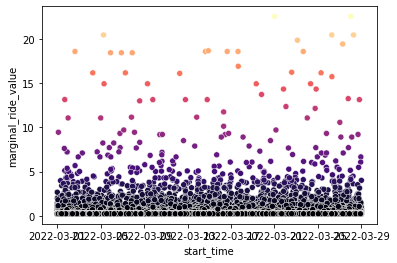

In [ ]:
sns.scatterplot( x = 'start_time', y='marginal_ride_value',
                     data=df,
                     c = df.marginal_ride_value,
                     cmap='magma')

(0.0, 0.5)

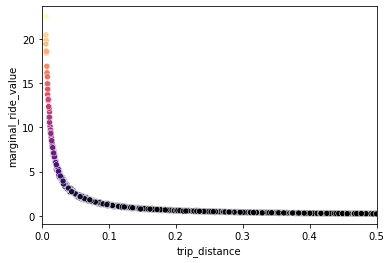

In [ ]:
sns.scatterplot( x = 'trip_distance', y='marginal_ride_value',
                     data=df,
                     c = df.marginal_ride_value,
                     cmap='magma')
plt.xlim(0,0.5)

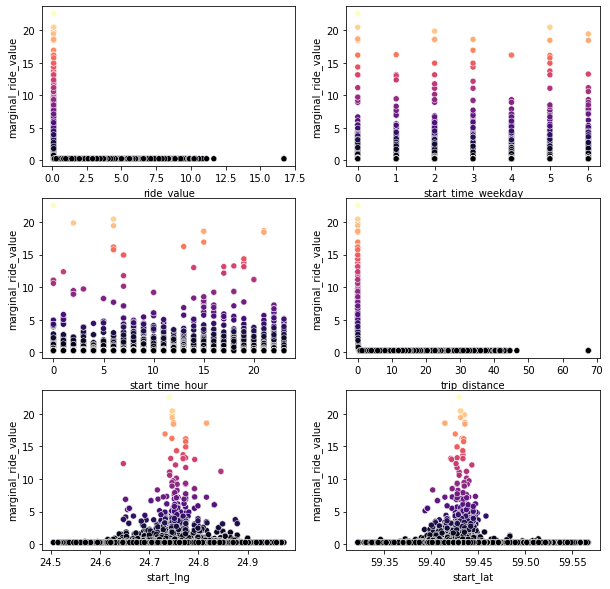

In [ ]:
for i, column in enumerate(['ride_value', 'start_time_weekday', 'start_time_hour', 'trip_distance', 'start_lng', 'start_lat'], 1):
    plt.subplot(3,2,i)
    sns.scatterplot( x = column, y='marginal_ride_value',
                     data=df,
                     c = df.marginal_ride_value,
                     cmap='magma')

  

plt.gcf().set_size_inches(10,10)



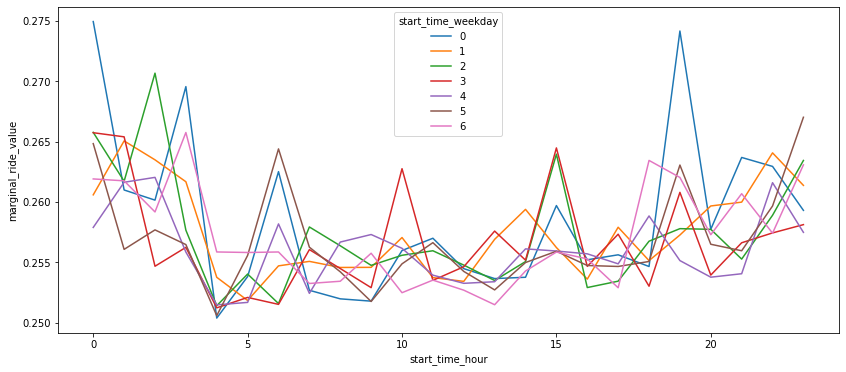

In [ ]:
# display pivot table
df.pivot_table('marginal_ride_value', index='start_time_hour', columns='start_time_weekday').plot(figsize=(14,6))
plt.ylabel('marginal_ride_value');

## Conclusions

*   Although most maringal ride value is around the mean of around 25.5ct there are also high value rides which are normally very short in distance. This might be due to slow traffic at rush hours and our simplified distance model.
*   High marginal ride value is clustered in the city centre -> map to confirm.
*   Rush hour leads to peaks of marginal ride value.
*   Base level at night is higher than during the day, especially from midnight to 3 am.
*   Weekday matters for rush hour peaks, for example Monday evening and Saturday morning.





## Maps

In [ ]:
def select_within_boundingbox(df, boundry):
    return (df.start_lng >= boundry[0]) & (df.start_lng <= boundry[1]) & \
           (df.start_lat >= boundry[2]) & (df.start_lat <= boundry[3]) & \
           (df.end_lng >= boundry[0]) & (df.end_lng <= boundry[1]) & \
           (df.end_lat >= boundry[2]) & (df.end_lat <= boundry[3])

In [ ]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

def plot_osm(df,  boundry, marginal_limit, t = 'all', zoom = 10, figsize=(20, 20), c=('red', 'grey')):

  idx = select_within_boundingbox(df, boundry)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  cm = plt.cm.get_cmap('RdYlBu_r')
  tmp = df[idx]

  if t != 'all':
    tmp = tmp[tmp.start_time_hour.eq(t)]

  request = cimgt.OSM()
  ax = plt.axes(projection=request.crs)
  ax.set_extent(boundry)
  ax.add_image(request, zoom)   


  ax.scatter(tmp[tmp.marginal_ride_value <= marginal_limit].start_lng, tmp[tmp.marginal_ride_value <= marginal_limit].start_lat,  s=1, alpha=0.2, c = c[1], transform=ccrs.PlateCarree())
  ax.scatter(tmp[tmp.marginal_ride_value > marginal_limit].start_lng, tmp[tmp.marginal_ride_value > marginal_limit].start_lat,  s=1, alpha=0.2, c = c[0], transform=ccrs.PlateCarree())

  ax.set_title(t)

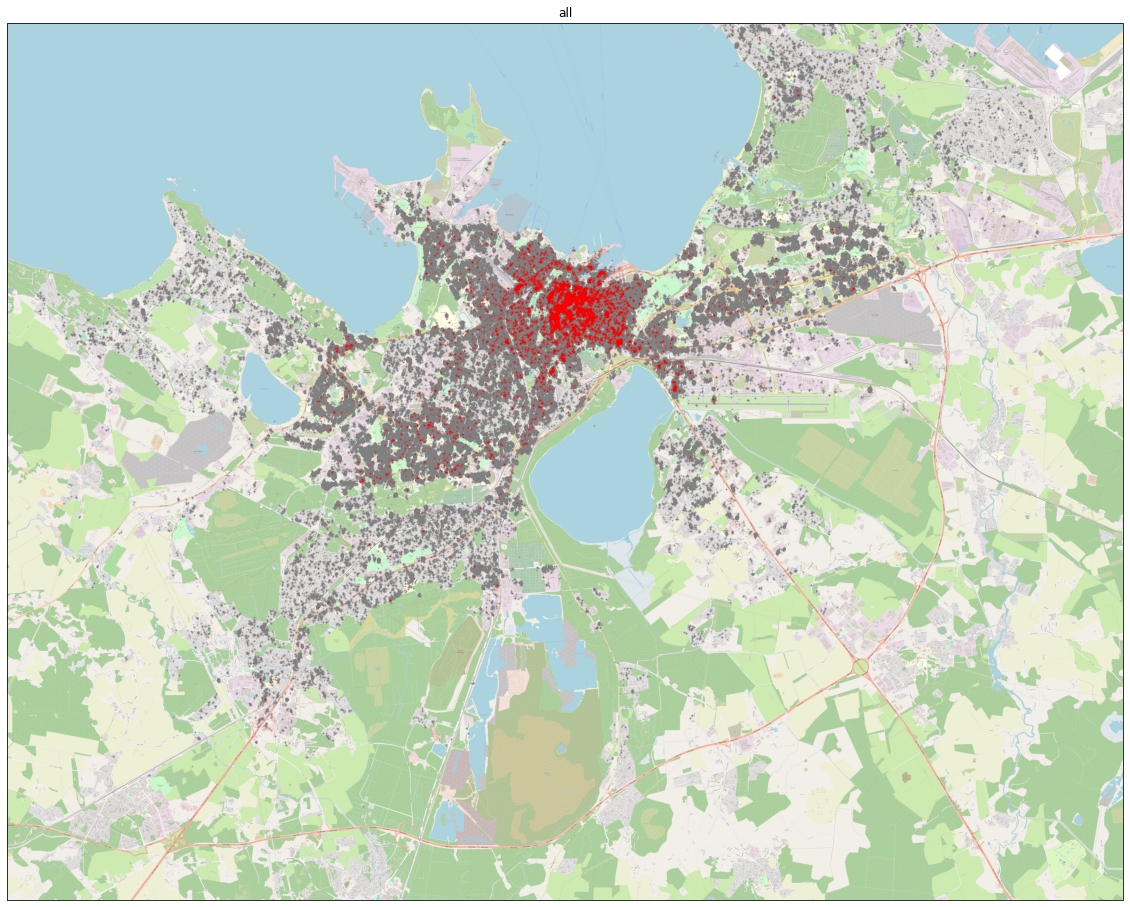

In [ ]:
plot_osm(df, boundry = [24.5, 25, 59.3, 59.5], marginal_limit = 0.2555, t = 'all', zoom = 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


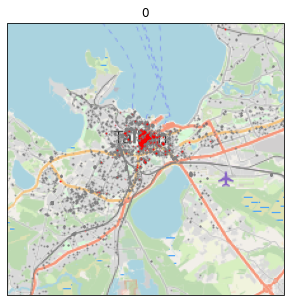

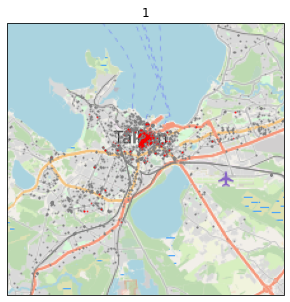

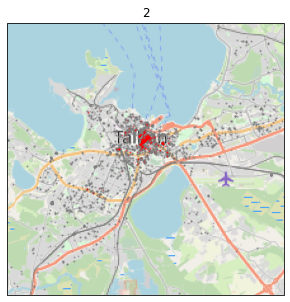

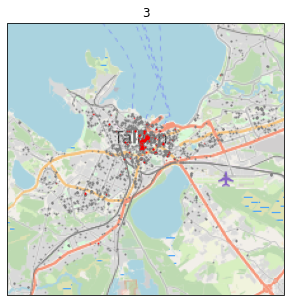

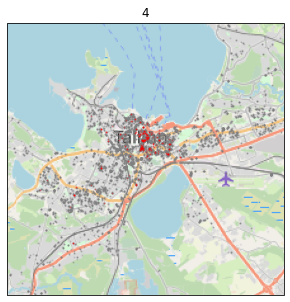

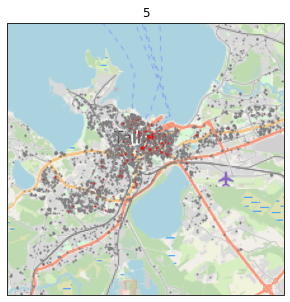

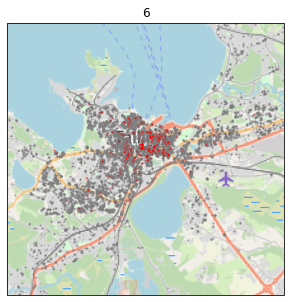

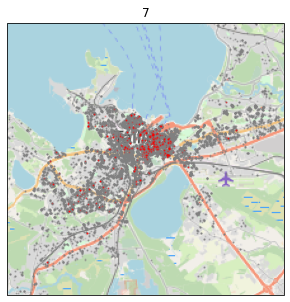

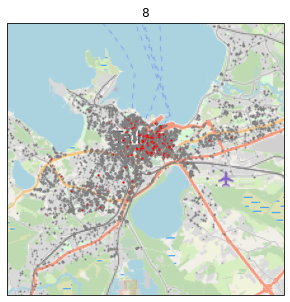

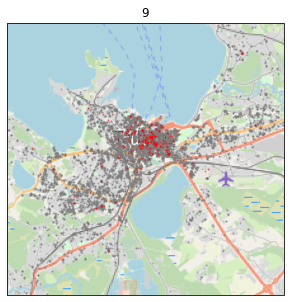

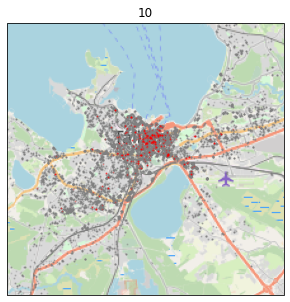

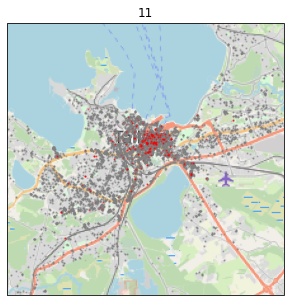

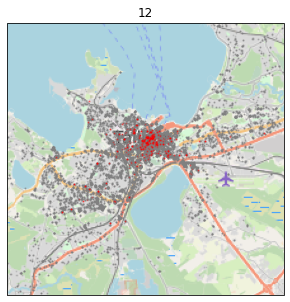

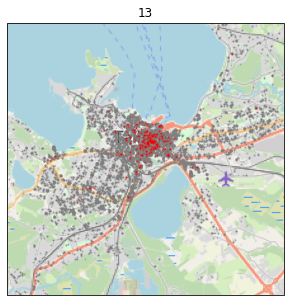

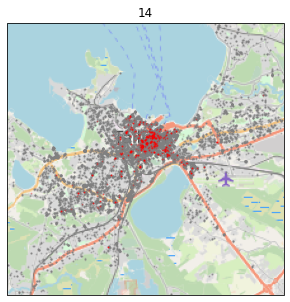

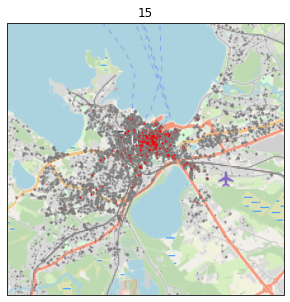

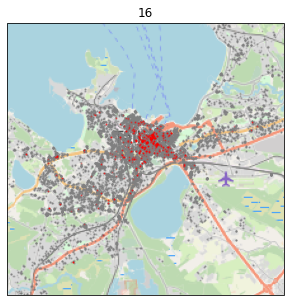

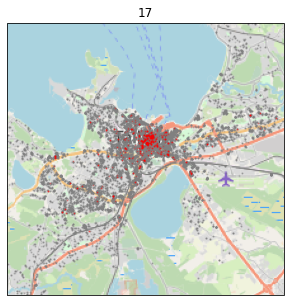

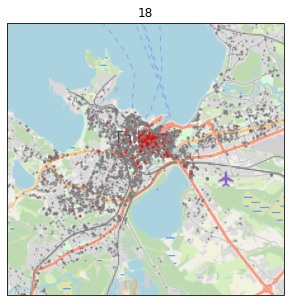

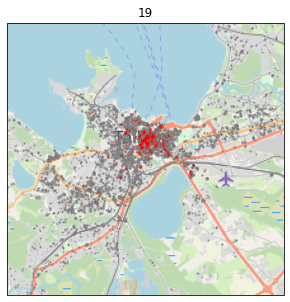

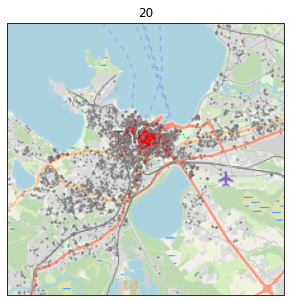

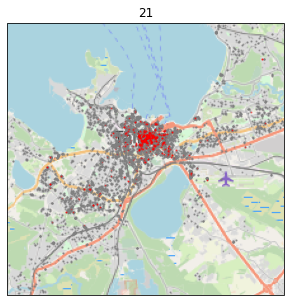

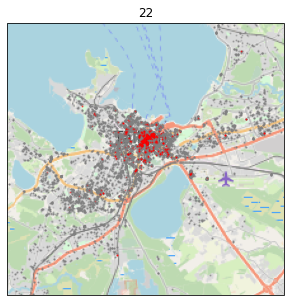

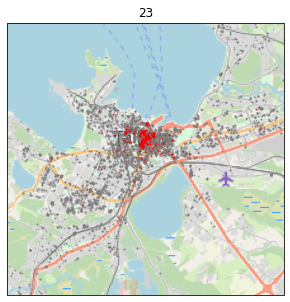

In [ ]:
# loop here over time of day
for h in range(0,24):
  plot_osm(df, boundry = [24.6, 24.9, 59.35, 59.5], marginal_limit = 0.2555, t= h, zoom = 10, figsize=(5, 5))


## Conclusions

We see some spatial clusters mainly in the city center. It would be intersting to plot the cluster with the highest marginal per h.

# Model

## Aggregate over time and space

### Space

In [ ]:
#simple kmeans algo with 30 clusters
from scipy.cluster.vq import kmeans2

clusters = 30

cluster_centroid, cluster_label = kmeans2((df[[ 'start_lat', 'start_lng']]), clusters, iter = 20)  


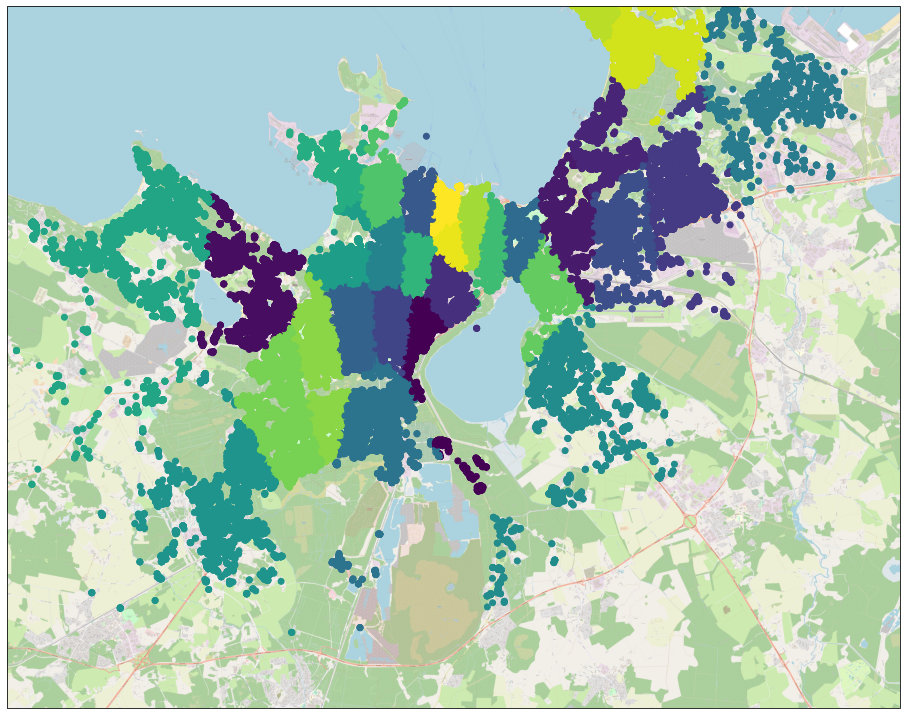

In [ ]:
zoom = 15

fig, ax = plt.subplots(1, 1, figsize=figsize)


request = cimgt.OSM()
ax = plt.axes(projection=request.crs)
ax.set_extent(boundry)
ax.add_image(request, zoom)   


ax.scatter(df.start_lng, df.start_lat, c=cluster_label, transform=ccrs.PlateCarree());


In [ ]:
# prepare cluster data for concat
cluster_centroid = pd.DataFrame(cluster_centroid)

cluster_centroid = cluster_centroid.reset_index()
cluster_centroid.columns =['cluster','cluster_centroid_lat', 'cluster_centroid_lng']

In [ ]:
cluster_label = pd.DataFrame(cluster_label)
cluster_label.columns =['cluster']


In [ ]:
# combine df and cluster data
df = pd.concat([df,cluster_label ],axis = 1)
df = df.merge(cluster_centroid,  on = 'cluster')

### Time

In [ ]:
df = df.set_index('start_time')

In [ ]:
# aggregate to 15m intervals
df = df.groupby([pd.Grouper(freq = "15T"), "cluster"])\
      .agg({"cluster_centroid_lat": np.mean,
            "cluster_centroid_lng": np.mean,
            "start_time_weekday": np.mean,
            "start_time_hour": np.mean,       
            "marginal_ride_value": np.mean,
            "ride_value": np.sum,
            "trip_distance": np.sum,
            'end_lng':'count'})
df = df.rename(columns={"end_lng": "rides"})

## Rank clusters by value

In [ ]:
df['rank'] = df.groupby(['start_time'])["marginal_ride_value"].rank(method='first',ascending=False).astype(int) # Nr 1 has highest value

## Transform:


### Train, test split

Preprocessor (not really necessary for XGB): 

*  Scale for numerical and OneHotEncoder for categorical


In [ ]:
df_model = df.reset_index()

In [ ]:
numeric_features=[     'start_time_weekday',
 	                     'start_time_hour'
								 ]

categorical_features=['cluster']
label_column = ['rank']



In [ ]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# Transform: oneHotEncoder for categorical
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


# Preprocessor - Scale and Encode
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### Split into Train and Test

Note: The preprocessor which was fit to the train set is applied to the test set after the split to avoid information leackage.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(label_column, axis = 1, inplace = False), df_model[label_column], test_size=0.1, random_state=0)

## Inference Model

The inference model predicts a ranking of spatial clusters by mean marginal ride value.

In [ ]:
model = Pipeline(steps=[('pre', preprocessor),
                        ('XGB', XGBRegressor(
                                       eval_metric = 'rmse',
                                       objective = 'reg:squarederror',
                                       cv =5))])

In [ ]:
clf =model.fit(X_train, y_train)

### Evaluate inference model with test set

In [ ]:
y_pred = np.ndarray.astype(np.around(clf.predict(X_test), decimals=0), int)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("MAE: %.5f" % mae)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))



MAE: 5.23479
MSE: 41.18241
RMSE: 6.41735


Not great, would need additional features to improve.

## Recommendation model

The recommendation model takes the info of the driver location, filters for reachable clusters and predicts the ranking and returns the coordinates of the most valuable cluster.

In [ ]:
def distance_to_cluster(df, location):
    distance = haversine_np(df['cluster_centroid_lng'], df['cluster_centroid_lat'], location[0], location[1])
    return distance

In [ ]:
def find_reachable_clusters(location, avg_speed, cluster_centroid, interval):

    """
    
    Determine the reachable clusters by the set time interval [h] and average speed [km/h].

    """

    travel_distance = interval * avg_speed

    reachable = cluster_centroid[distance_to_cluster(cluster_centroid, location) <= travel_distance]

    return reachable 

    

In [ ]:
def location_recommendation(current_time, reachable_clusters):

     
  """

  Return the best ranked cluster given a list of reachable clusters and the current_time in datatime format.

  """

  if len(reachable_clusters) < 1:
    raise ValueError('No reachable clusters')

  # extract time_weekday and time hour which are the features the model predicts on
  start_time_weekday = current_time.weekday()
  start_time_hour    = current_time.hour


  # loop over reachable clusters and predict their rank
  for i in reachable_clusters.index:
    
    # construct X 
    cluster_predict = {'cluster': [reachable_clusters.cluster[i]] ,'start_time_weekday': [current_time.weekday()], 'start_time_hour': [current_time.hour]}

    cluster_predict = pd.DataFrame(data=cluster_predict)
    reachable_clusters.at[i, 'rank'] = np.ndarray.astype(np.around(clf.predict(cluster_predict), decimals=0), int)

    #sort by rank and return best ranked

  best_ranked_cluster = reachable_clusters.sort_values("rank")[:1]



  return best_ranked_cluster

    

### Test

In [ ]:
# test data
interval = 0.25
avg_speed = 15
location = [24.671254, 59.380619]

travel_distance = interval * avg_speed

from datetime import datetime
current_time = datetime.now()

In [ ]:
reachable_clusters = find_reachable_clusters(location, avg_speed, cluster_centroid, interval)
best_ranked_cluster = location_recommendation(current_time, reachable_clusters)

In [ ]:
best_ranked_cluster

cluster  cluster_centroid_lat  cluster_centroid_lng  rank
11       11             59.384843             24.710178   9.0

# Export html

In [ ]:
%%shell
jupyter nbconvert --to html /content/BoltAssignmentSklearnXGBClustering.ipynb

[NbConvertApp] Converting notebook /content/BoltAssignmentSklearnXGBClustering.ipynb to html
[NbConvertApp] Writing 7477190 bytes to /content/BoltAssignmentSklearnXGBClustering.html


# Additional data that would be useful


1.   Drivers supply
2.   Drivers speed
3.   Driver preference for minimum ride length
4.   Rider maximal waiting time
5.   Longer time horizon training data to cover seasons
6.   Weather
7.   Socioeconomic data of city areas





# Deployment

*Describe how you would deploy such a model.*

For deployment,we would have to add proper testing before we can expose the location_recommendation part of the model to an endpoint on a distributed cloud service with an API the drivers' app can send requests to.

The inference part of the model currently only relies on time features. Therefore, we can use batch predictions and retrain the model by a set time interval. Amazon SageMaker is part of Bolt's stack and offers a wide variety of benefits, such as integration with other AWS services as well as Spark and Airflow, build in XGBoost algorithm and smart hyperparameter tuning. This makes it an ideal candidate for deploying the model.




# AB testing

*Think through and describe the randomized experiment (AB-test) for live operations.*


##Identify goals and define key sucess metrics
Since we introduce a new feature we could use a fixed horizon A/B test. Essentially the new feature should incentivize our drivers to make better decisions on where to be located. As a result, key metrics should improve such as completed trips, driver supply time, driver retention and waiting time. While considering these metrics, as a evaluation metric I would propose revenue per driver.

Since the driver supply of high value regions might cannibalise low value regions, we should further have an eye on metrics that might be negatively impacted such as number of trips taken by new riders that start in low value areas.


##Hypothesis
Deploying our location recommendation feature for drivers will improve our revenue per driver.

##Estimate test duration with a sample size and 

## Preprocess data

Preprocessing steps might include Outlier detection to improve the robustness, Variance reduction to increase the statistical power. Depending on the diversitz, Diff-in-Diff to deal with Pre-experiment bias.



## Run the test

First run the test on a small sample for sanity checking. Then apply to tretment group. It might be hard to shuffle drivers all the time so be aware of carry over effects.

## Test hypothesis

Unequal variances t-test to calculate P value and confidence interval.

## Decide on shipping of the feature


